## Imports and Data Loading

We import necessary modules/functons and raw data from [`data\raw`](<..\data\raw>).

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.regularizers import l2

# load data
data = pd.read_excel(os.path.join('..', 'data', 'raw', 'market_data.xlsx'), index_col='Date', usecols=['Date', 'PE', 'CPI', 'M2', '_MKT'])

## Feature Engineering

To implement a trading strategy based on the gap between M2 and CPI, as well as higher or lower PE, we create additional features reflecting these relationships and feed them into our CNN-LSTM model.

In [ ]:
# M2 CPI growth gap
data['M2_Growth'] = data['M2'].pct_change()
data['CPI_Growth'] = data['CPI'].pct_change()
data['M2_CPI_Growth_Comparison'] = np.where(data['M2_Growth'] > data['CPI_Growth'], 1, 0)  # 1 if M2 growth > CPI growth, else 0

# PE
data['PE_High_Low'] = np.where(data['PE'] > data['PE'].median(), 1, 0)  # 1 for high PE, 0 for low PE

# drop rows with NaN values after rolling
data = data.dropna()

# scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

scaled_data.to_csv(os.path.join('..', 'data', 'processed', 'scaled_feature_data.csv'), index='Data')

def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data.iloc[i:(i + lag)].values)
        y.append(data.iloc[i + lag]['_MKT'])
    return np.array(X), np.array(y)

# lagged dataset
lag = 4 # use prev 4 week data to predict (approx. 1 month)
X, y = create_lagged_dataset(scaled_data, lag=lag)

# time-based split (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# input shape
input_shape = (X.shape[1], X.shape[2])

In [4]:
# build
inputs = Input(shape=input_shape)
x = Conv1D(filters=16, kernel_size=2, activation='relu')(inputs)
x = Conv1D(filters=32, kernel_size=2, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Reshape((8, 1))(x)
x = LSTM(50, return_sequences=True)(x)
x = LSTM(50)(x)
outputs = Dense(1)(x)

# compile
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# train
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0)

# predict
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [5]:
# evaluate model
is_mse = mean_squared_error(y_train, train_predictions)
is_rmse = np.sqrt(is_mse)
is_mae = mean_absolute_error(y_train, train_predictions)
is_mape = mean_absolute_percentage_error(y_train, train_predictions)
is_r2 = r2_score(y_train, train_predictions)
os_mse = mean_squared_error(y_test, test_predictions)
os_rmse = np.sqrt(os_mse)
os_mae = mean_absolute_error(y_test, test_predictions)
os_mape = mean_absolute_percentage_error(y_test, test_predictions)
os_r2 = r2_score(y_test, test_predictions)

print(f'In-Sample MSE: {is_mse}')
print(f'Out-of-Sample MSE: {os_mse}')
print(f'In-Sample RMSE: {is_rmse}')
print(f'Out-of-Sample RMSE: {os_rmse}')
print(f'In-Sample MAE: {is_mae}')
print(f'Out-of-Sample MAE: {os_mae}')
print(f'In-Sample MAPE: {is_mape}')
print(f'Out-of-Sample MAPE: {os_mape}')
print(f'In-Sample R2: {is_r2}')
print(f'Out-of-Sample R2: {os_r2}')

In-Sample MSE: 3.194199600089131e-05
Out-of-Sample MSE: 0.0011648416145054559
In-Sample RMSE: 0.005651725046469556
Out-of-Sample RMSE: 0.03412977606878568
In-Sample MAE: 0.004142206471238833
Out-of-Sample MAE: 0.025646185477084974
In-Sample MAPE: 17551528639.771626
Out-of-Sample MAPE: 0.03915809339442147
In-Sample R2: 0.9967220409303738
Out-of-Sample R2: 0.9579999395018585


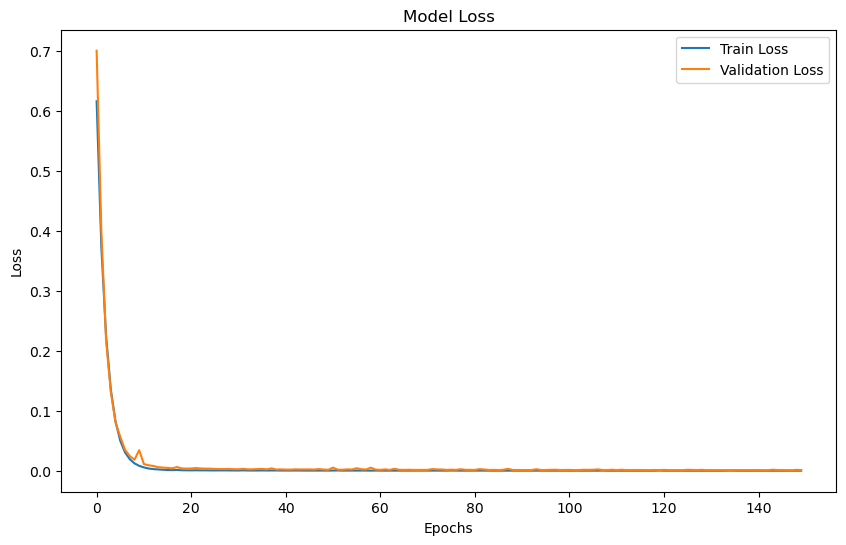

In [6]:
# training & validation loss values as fxn of epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

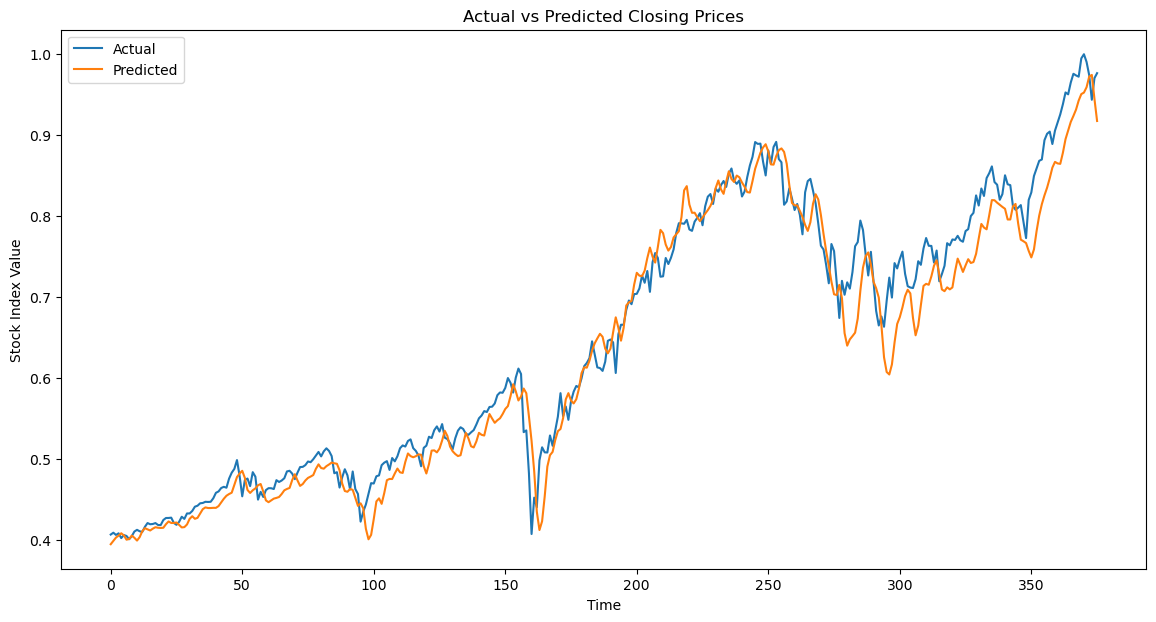

In [7]:
# actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Index Value')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

In [29]:
from sklearn.model_selection import TimeSeriesSplit

# k-fold
tscv = TimeSeriesSplit(n_splits=5)
cross_val_results = []

for train_index, test_index in tscv.split(X):
    X_train_cv, X_test_cv = X[train_index], X[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # train
    model.fit(X_train_cv, y_train_cv, epochs=150, validation_data=(X_test_cv, y_test_cv), verbose=0)

    # predict
    test_predictions_cv = model.predict(X_test_cv)
    
    # evaluate
    mse_cv = mean_squared_error(y_test_cv, test_predictions_cv)
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = mean_absolute_error(y_test_cv, test_predictions_cv)
    mape_cv = mean_absolute_percentage_error(y_test_cv, test_predictions_cv)
    r2_cv = r2_score(y_test_cv, test_predictions_cv)
    
    cross_val_results.append((mse_cv, rmse_cv, mae_cv, mape_cv, r2_cv))

# avg metrics
avg_cross_val_results = np.mean(cross_val_results, axis=0)
print(f'Cross-Validation MSE: {avg_cross_val_results[0]}')
print(f'Cross-Validation RMSE: {avg_cross_val_results[1]}')
print(f'Cross-Validation MAE: {avg_cross_val_results[2]}')
print(f'Cross-Validation MAPE: {avg_cross_val_results[3]}')
print(f'Cross-Validation R2: {avg_cross_val_results[4]}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Cross-Validation MSE: 0.0019066441032055035
Cross-Validation RMSE: 0.03968253819027978
Cross-Validation MAE: 0.032680604455960764
Cross-Validation MAPE: 0.15947425072372168
Cross-Validation R2: 0.20942592920953967


## Additional Trading Signals

We use the model predictions along with the new features to generate trading signals: M2/CPI gap and relative level of P/E.

In [22]:
def generate_additional_signals(data):
    m2_growth = data['M2'].pct_change()
    cpi_growth = data['CPI'].pct_change()
    pe_ratio = data['PE']

    # signal based on M2 and CPI gap
    gap_signal = np.where(m2_growth > cpi_growth, 1, -1)  # buy if M2 growth > CPI growth, sell otherwise
    
    # signal based on PE ratio
    pe_signal = np.where(pe_ratio > pe_ratio.median(), -1, 1)  # sell if PE > mean PE, buy otherwise
    
    return gap_signal, pe_signal

gap_signal, pe_signal = generate_additional_signals(data)

## M2 and CPI Gap

A significant gap where M2 growth exceeds CPI growth suggests that the market is flush with liquidity, supporting asset prices without triggering immediate inflationary concerns. This scenario is typically favorable for equities, as low inflation allows for lower interest rates, making borrowing cheaper for companies and enhancing future earnings potential.

In [23]:
gap_signal_train = gap_signal[1:train_size]
gap_signal_test = gap_signal[train_size+lag+1:]
pe_signal_train = pe_signal[1:train_size]
pe_signal_test = pe_signal[train_size+lag+1:]

def calculate_pnl(signals, returns):
    return signals * returns  # PnL

# check robustness to implementation delay
def calculate_pnl2(signals, returns):
    return signals[1:] * returns[:-1]

# market returns
market_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
market_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values

train_pnl_gap = calculate_pnl(gap_signal_train, market_returns_train)
test_pnl_gap = calculate_pnl(gap_signal_test, market_returns_test)
train_pnl_gap2 = calculate_pnl2(gap_signal_train, market_returns_train)
test_pnl_gap2 = calculate_pnl2(gap_signal_test, market_returns_test)

# cumulative returns
train_cumulative_pnl = np.cumsum(train_pnl_gap)
test_cumulative_pnl = np.cumsum(test_pnl_gap)
train_cumulative_pnl2 = np.cumsum(train_pnl_gap2)
test_cumulative_pnl2 = np.cumsum(test_pnl_gap2)

# IR
def calculate_ir(pnl, market_returns):
    excess_returns = pnl - market_returns[:len(pnl)]
    return (np.mean(excess_returns) / np.std(excess_returns)) * np.sqrt(52)  # Annualized IR

train_ir = calculate_ir(train_pnl_gap, market_returns_train)
test_ir = calculate_ir(test_pnl_gap, market_returns_test)
train_ir2 = calculate_ir(train_pnl_gap2, market_returns_train[:-1])
test_ir2 = calculate_ir(test_pnl_gap2, market_returns_test[:-1])

print(f'In-Sample IR for gap [t+1]: {train_ir}')
print(f'Out-of-Sample IR for gap [t+1]: {test_ir}')
print(f'In-Sample IR for gap [t+2]: {train_ir2}')
print(f'Out-of-Sample IR for gap [t+2]: {test_ir2}')

# underlying strategy returns
def calculate_buy_and_hold_returns(data, train_size, lag):
    bh_returns_train = data['_MKT'].iloc[:train_size].pct_change().dropna().values
    bh_returns_test = data['_MKT'].iloc[train_size+lag:].pct_change().dropna().values
    
    bh_cumulative_returns_train = np.cumsum(bh_returns_train)
    bh_cumulative_returns_test = np.cumsum(bh_returns_test)
    
    return bh_cumulative_returns_train, bh_cumulative_returns_test

bh_cumulative_returns_train, bh_cumulative_returns_test = calculate_buy_and_hold_returns(data, train_size, lag)


In-Sample IR for gap [t+1]: -0.7126953955089013
Out-of-Sample IR for gap [t+1]: -0.7475503880268383
In-Sample IR for gap [t+2]: -0.7485924865152461
Out-of-Sample IR for gap [t+2]: -0.4677595848697072


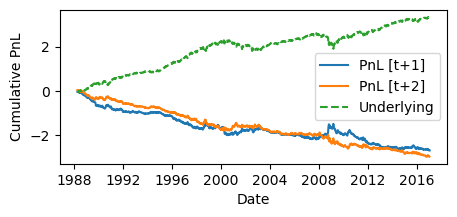

In [24]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl)+1], train_cumulative_pnl, label='PnL [t+1]')
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl2)+1], train_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[:train_size][1:len(bh_cumulative_returns_train)+1], bh_cumulative_returns_train, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

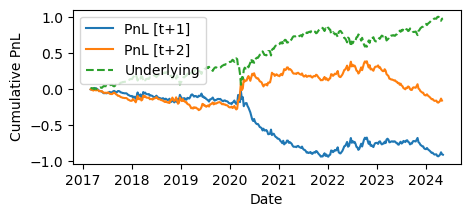

In [25]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl)+1], test_cumulative_pnl, label='PnL [t+1]')
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl2)+1], test_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[train_size+lag:][1:len(bh_cumulative_returns_test)+1], bh_cumulative_returns_test, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

## P/E Signalling

Here we implement the P/E ratio as a trading signal. A higher P/E ratio implies that investors are willing to pay more for each unit of earnings, often due to expectations of higher future growth. Conversely, a lower P/E ratio might indicate undervaluation or pessimistic growth expectations. By categorizing P/E ratios as high or low relative to a median or benchmark, investors can gauge market sentiment and valuation extremes.


In [26]:
train_pnl_pe = calculate_pnl(pe_signal_train, market_returns_train)
test_pnl_pe = calculate_pnl(pe_signal_test, market_returns_test)
train_pnl_pe2 = calculate_pnl2(pe_signal_train, market_returns_train)
test_pnl_pe2 = calculate_pnl2(pe_signal_test, market_returns_test)

# cumulative returns
train_cumulative_pnl = np.cumsum(train_pnl_pe)
test_cumulative_pnl = np.cumsum(test_pnl_pe)
train_cumulative_pnl2 = np.cumsum(train_pnl_pe2)
test_cumulative_pnl2 = np.cumsum(test_pnl_pe2)

train_ir = calculate_ir(train_pnl_pe, market_returns_train)
test_ir = calculate_ir(test_pnl_pe, market_returns_test)
train_ir2 = calculate_ir(train_pnl_pe2, market_returns_train[:-1])
test_ir2 = calculate_ir(test_pnl_pe2, market_returns_test[:-1])

print(f'In-Sample IR for PE [t+1]: {train_ir}')
print(f'Out-of-Sample IR for PE [t+1]: {test_ir}')
print(f'In-Sample IR for PE [t+2]: {train_ir2}')
print(f'Out-of-Sample IR for PE [t+2]: {test_ir2}')

In-Sample IR for PE [t+1]: -0.5309895357393172
Out-of-Sample IR for PE [t+1]: -1.2450670114690015
In-Sample IR for PE [t+2]: -0.45595588442401125
Out-of-Sample IR for PE [t+2]: -1.15557811649309


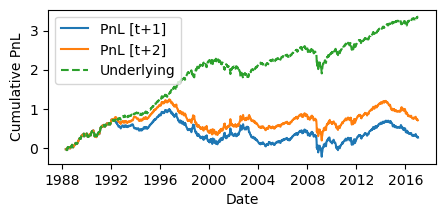

In [27]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl)+1], train_cumulative_pnl, label='PnL [t+1]')
plt.plot(data.index[:train_size][1:len(train_cumulative_pnl2)+1], train_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[:train_size][1:len(bh_cumulative_returns_train)+1], bh_cumulative_returns_train, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()

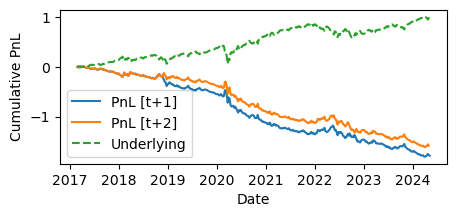

In [28]:
# plot
plt.figure(figsize=(5, 2))
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl)+1], test_cumulative_pnl, label='PnL [t+1]')
plt.plot(data.index[train_size+lag:][1:len(test_cumulative_pnl2)+1], test_cumulative_pnl2, label='PnL [t+2]')
plt.plot(data.index[train_size+lag:][1:len(bh_cumulative_returns_test)+1], bh_cumulative_returns_test, label='Underlying', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.show()